### Introducción

En este trabajo exploraremos las herramientas de *Python* para crear e interacturar con archivos *SQL*. Para esto crearemos una base de datos con los datos de los casos de dengue en méxico en el 2023, los cuales se encuentran en esta [página](https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-de-enfermedades-transmitidas-por-vector). Después, exploraremos los datos para resaltar resultados interesantes, o preocupantes, de esta enfermedad en el año actual. Por último, crearemos vistas y funciones que muestren información útil para cualquier persona que explore la base de datos.

### Librerías

In [48]:
import re
import zipfile
import sqlite3
import requests
import pandas as pd
from io import BytesIO
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### Descarga de datos

In [24]:
# Link de descarga de los datos
url = "https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/etv/historicos/2023/datos_abiertos_dengue_261023.zip"

# Descarga los datos y los guarda en un objeto de tipo BytesIO
response = requests.get(url)
zip_file = BytesIO(response.content)

# Extrae los datos del objeto zip_file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.\\data') # Cambia 'ruta' por la ruta donde deseas extraer los archivos

In [25]:
# Leer el archivo de datos 
df = pd.read_csv('data/dengue_abierto.csv')

# Muestra los primeros registros para verificar que la lectura fue exitosa
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,HABLA_LENGUA_INDIG,INDIGENA,ENTIDAD_UM_NOTIF,MUNICIPIO_UM_NOTIF,...,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,DICTAMEN,TOMA_MUESTRA,RESULTADO_PCR,ESTATUS_CASO,ENTIDAD_ASIG,MUNICIPIO_ASIG
0,2023-10-23,1004648,1,17,23,5,2,2,23,5,...,2,2,2,2,5.0,1,3,2,23,5
1,2023-10-23,1004661,2,25,23,5,2,2,23,5,...,2,2,2,2,5.0,1,5,3,23,5
2,2023-10-23,1004693,2,8,19,21,2,2,19,21,...,2,2,2,2,5.0,1,5,3,19,21
3,2023-10-23,1004728,1,64,25,1,2,2,25,1,...,2,2,2,2,5.0,1,5,3,25,1
4,2023-10-23,1004754,1,30,6,2,2,2,6,2,...,2,2,2,2,5.0,1,5,3,6,2


### Creación de base de datos

Antes de crear la base de datos, imputaremos los datos faltantes o nulos. Primero, crearemos archivos CSV de los catálogos de las variables no numéricas para facilitar su posterior mapeo.

In [26]:
# Crear diccionarios csv
diccionario = pd.read_excel('Catálogos_Dengue.xlsx', sheet_name=None)

# Sacamos los diccionarios en formato csv leyendo cada sheet del archivo
for sheet_name, sheet_data in diccionario.items():
    # Reemplaza los espacios en el nombre de la hoja con guiones bajos
    nombre_archivo_csv = f"{re.sub(r'C[ÁA]T[ÁA]LOGO', '', sheet_name).replace(' ', '')}.csv"
    sheet_data.to_csv(f'data/{nombre_archivo_csv}', index=False)

Buscando por datos `NA`, vemos que solo la variable "DICTAMEN" tiene 2 valores `NA`. Cambiaremos estos valores a "5", este valor significa "NO APLICA" como se ve en su catálogo.

In [27]:
# Verificamos si hay valores nulos
df.isna().sum()

FECHA_ACTUALIZACION       0
ID_REGISTRO               0
SEXO                      0
EDAD_ANOS                 0
ENTIDAD_RES               0
MUNICIPIO_RES             0
HABLA_LENGUA_INDIG        0
INDIGENA                  0
ENTIDAD_UM_NOTIF          0
MUNICIPIO_UM_NOTIF        0
INSTITUCION_UM_NOTIF      0
FECHA_SIGN_SINTOMAS       0
TIPO_PACIENTE             0
HEMORRAGICOS              0
DIABETES                  0
HIPERTENSION              0
ENFERMEDAD_ULC_PEPTICA    0
ENFERMEDAD_RENAL          0
INMUNOSUPR                0
CIRROSIS_HEPATICA         0
EMBARAZO                  0
DEFUNCION                 0
DICTAMEN                  2
TOMA_MUESTRA              0
RESULTADO_PCR             0
ESTATUS_CASO              0
ENTIDAD_ASIG              0
MUNICIPIO_ASIG            0
dtype: int64

In [28]:
# Reemplazamos los valores nulos de la columna 'DICTAMEN' por 5, que es el valor que indica que no se tiene dictamen
df['DICTAMEN'] = df['DICTAMEN'].fillna(5)

In [29]:
# Verificamos los cambios
df.isna().sum()

FECHA_ACTUALIZACION       0
ID_REGISTRO               0
SEXO                      0
EDAD_ANOS                 0
ENTIDAD_RES               0
MUNICIPIO_RES             0
HABLA_LENGUA_INDIG        0
INDIGENA                  0
ENTIDAD_UM_NOTIF          0
MUNICIPIO_UM_NOTIF        0
INSTITUCION_UM_NOTIF      0
FECHA_SIGN_SINTOMAS       0
TIPO_PACIENTE             0
HEMORRAGICOS              0
DIABETES                  0
HIPERTENSION              0
ENFERMEDAD_ULC_PEPTICA    0
ENFERMEDAD_RENAL          0
INMUNOSUPR                0
CIRROSIS_HEPATICA         0
EMBARAZO                  0
DEFUNCION                 0
DICTAMEN                  0
TOMA_MUESTRA              0
RESULTADO_PCR             0
ESTATUS_CASO              0
ENTIDAD_ASIG              0
MUNICIPIO_ASIG            0
dtype: int64

Ahora creamos la base de datos, la llamaremos `mcd` y a la tabla `dengue_2023`.

In [30]:
# Crear la base de datos SQLite
conn = sqlite3.connect('mcd.db')

# Enviar el DataFrame a la base de datos SQLite
df.to_sql('dengue_2023', conn, index=False, if_exists='replace')

# Cerrar la conexión
conn.close()

### Limpieza de los datos

En esta parte, ajustaremos los tipos de las variables para optimizar el `dataframe`.

In [31]:
# Leer el dataframe desde la base de datos SQLite
conn = sqlite3.connect('mcd.db')
df = pd.read_sql('SELECT * FROM dengue_2023', conn)

# Muestra los primeros registros para verificar que la lectura fue exitosa
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,HABLA_LENGUA_INDIG,INDIGENA,ENTIDAD_UM_NOTIF,MUNICIPIO_UM_NOTIF,...,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,DICTAMEN,TOMA_MUESTRA,RESULTADO_PCR,ESTATUS_CASO,ENTIDAD_ASIG,MUNICIPIO_ASIG
0,2023-10-23,1004648,1,17,23,5,2,2,23,5,...,2,2,2,2,5.0,1,3,2,23,5
1,2023-10-23,1004661,2,25,23,5,2,2,23,5,...,2,2,2,2,5.0,1,5,3,23,5
2,2023-10-23,1004693,2,8,19,21,2,2,19,21,...,2,2,2,2,5.0,1,5,3,19,21
3,2023-10-23,1004728,1,64,25,1,2,2,25,1,...,2,2,2,2,5.0,1,5,3,25,1
4,2023-10-23,1004754,1,30,6,2,2,2,6,2,...,2,2,2,2,5.0,1,5,3,6,2


In [32]:
# Analizamos la estructura de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202762 entries, 0 to 202761
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FECHA_ACTUALIZACION     202762 non-null  object 
 1   ID_REGISTRO             202762 non-null  int64  
 2   SEXO                    202762 non-null  int64  
 3   EDAD_ANOS               202762 non-null  int64  
 4   ENTIDAD_RES             202762 non-null  int64  
 5   MUNICIPIO_RES           202762 non-null  int64  
 6   HABLA_LENGUA_INDIG      202762 non-null  int64  
 7   INDIGENA                202762 non-null  int64  
 8   ENTIDAD_UM_NOTIF        202762 non-null  int64  
 9   MUNICIPIO_UM_NOTIF      202762 non-null  int64  
 10  INSTITUCION_UM_NOTIF    202762 non-null  int64  
 11  FECHA_SIGN_SINTOMAS     202762 non-null  object 
 12  TIPO_PACIENTE           202762 non-null  int64  
 13  HEMORRAGICOS            202762 non-null  int64  
 14  DIABETES            

In [33]:
# Analizamos la estadística descriptiva de los datos
df.describe()

,ID_REGISTRO,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,HABLA_LENGUA_INDIG,INDIGENA,ENTIDAD_UM_NOTIF,MUNICIPIO_UM_NOTIF,INSTITUCION_UM_NOTIF,...,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,DICTAMEN,TOMA_MUESTRA,RESULTADO_PCR,ESTATUS_CASO,ENTIDAD_ASIG,MUNICIPIO_ASIG
count,2.027620e+05,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,...,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000,202762.000000
mean,1.114941e+06,1.462005,27.355318,21.841652,61.846268,1.975104,1.967558,21.857123,60.034735,7.617497,...,1.998210,1.999137,1.988173,1.996755,4.994836,1.535589,4.801822,1.573125,21.963440,62.893096
std,6.197239e+04,0.498555,17.908616,8.490932,81.429470,0.155809,0.177171,8.487523,81.969824,4.396052,...,0.042274,0.029366,0.108106,0.056874,0.107876,0.498733,0.715866,0.795658,8.829502,86.889775
min,8.527270e+05,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.062482e+06,1.000000,13.000000,17.000000,9.000000,2.000000,2.000000,17.000000,8.000000,4.000000,...,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,5.000000,1.000000,17.000000,9.000000
50%,1.116200e+06,1.000000,24.000000,23.000000,44.000000,2.000000,2.000000,23.000000,44.000000,5.000000,...,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,5.000000,1.000000,23.000000,44.000000
75%,1.168415e+06,2.000000,39.000000,30.000000,85.000000,2.000000,2.000000,30.000000,82.000000,12.000000,...,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,5.000000,2.000000,30.000000,85.000000
max,1.220335e+06,2.000000,118.000000,35.000000,570.000000,2.000000,2.000000,32.000000,999.000000,99.000000,...,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,5.000000,3.000000,99.000000,999.000000


Ahora, al explorar los catálogos nos damos cuenta de que solo tenemos números, a lo más, de 3 dígitos. Por lo que cambiaremos los tipos `int64` y `float64` a `uint8`.

In [34]:
# Seleccionamos las columnas con cada tipo
int64_columns = df.select_dtypes(include='int64').columns
float64_columns = df.select_dtypes(include='float64').columns

# Convertertimos las columnas int64 y float64 a uint16
df[int64_columns] = df[int64_columns].astype('uint16')
df[float64_columns] = df[float64_columns].astype('uint16')

También, cambiaremos los tipos de las variables temporales a `datetime`, tomando solamente la fecha y no la hora.

In [35]:
df['FECHA_ACTUALIZACION'] = pd.to_datetime(df['FECHA_ACTUALIZACION'], format='%Y-%m-%d')
df['FECHA_SIGN_SINTOMAS'] = pd.to_datetime(df['FECHA_SIGN_SINTOMAS'], format='%Y-%m-%d')

In [36]:
# Verificamos los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202762 entries, 0 to 202761
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA_ACTUALIZACION     202762 non-null  datetime64[ns]
 1   ID_REGISTRO             202762 non-null  uint16        
 2   SEXO                    202762 non-null  uint16        
 3   EDAD_ANOS               202762 non-null  uint16        
 4   ENTIDAD_RES             202762 non-null  uint16        
 5   MUNICIPIO_RES           202762 non-null  uint16        
 6   HABLA_LENGUA_INDIG      202762 non-null  uint16        
 7   INDIGENA                202762 non-null  uint16        
 8   ENTIDAD_UM_NOTIF        202762 non-null  uint16        
 9   MUNICIPIO_UM_NOTIF      202762 non-null  uint16        
 10  INSTITUCION_UM_NOTIF    202762 non-null  uint16        
 11  FECHA_SIGN_SINTOMAS     202762 non-null  datetime64[ns]
 12  TIPO_PACIENTE           202762

Este cambio lo hacemos para reducir el espacio de memoria y optimizar el rendimiento del algoritmo.

### Exploración de la base de datos

Primero exploraremos a nivel nacional los casos de dengue, para tener una vista general de la situación de dengue en el 2023. Se observa que en el mes de septiembre hubo un repunte de casos, lo cual es de esperarse al estarse acabando la temporada de lluvias en México. Siendo la humedad un factor favorable para la reproducción de los mosquitos. Por otro lado, los mosquitos no toleran las bajas temperaturas, por consiguiente, los casos bajan en invierno.

In [37]:
# Hacemos un análisis de los datos a través de gráficas 
casos_por_fecha = df.groupby('FECHA_SIGN_SINTOMAS').size().reset_index(name='CASOS')
fig = px.line(casos_por_fecha, x='FECHA_SIGN_SINTOMAS', y='CASOS', title='Casos de dengue por fecha de signos y síntomas')
fig.update_layout(xaxis_title='Fecha de signos y síntomas', yaxis_title='Casos')
fig.show()

Desarrollando un desgloze por estados, se observa que los estados más lluviosos y húmedos tienden a tener una mayor cantidad de casos de dengue. Esto se debe al ciclo de reproducción de los mosquitos, los cuales dejan sus huevos en agua estancada, además los lugaremos húmedos favorecen su supervivencia concordando con los resultados que se obtuvieron.

In [38]:
# Hacemos un mapeo de los casos por entidad
casos_por_entidad = df.groupby('ENTIDAD_RES').size().reset_index(name='CASOS')
entidad = pd.read_csv('data/ENTIDAD.csv')
entidad = entidad[['CLAVE_ENTIDAD', 'ENTIDAD_FEDERATIVA']]
casos_por_entidad = casos_por_entidad.merge(entidad, left_on = 'ENTIDAD_RES', right_on= 'CLAVE_ENTIDAD',how='left')

In [39]:
fig = px.bar(casos_por_entidad, x='ENTIDAD_FEDERATIVA', y='CASOS', title='Casos de dengue por entidad de residencia',
             category_orders={"ENTIDAD_FEDERATIVA": casos_por_entidad.sort_values(by='CASOS', ascending=False)['ENTIDAD_FEDERATIVA']},
             color='CASOS', labels={'CASOS': 'Número de casos'})
fig.update_layout(xaxis_title='Entidad de residencia', yaxis_title='Casos')
fig.show()

Centrándonos en el estado con mayor número de casos, siendo este Yucatán con más de 10 mil casos con respecto al siguiente estado. Encontamos que en la capital, Mérida, se concentran casi todos los casos, teniendo aproximadamente 5 veces más casos que cualquiera de los otros municipios.

In [40]:
casos_por_municipio_YN = df[df['ENTIDAD_RES'] == 31].groupby('MUNICIPIO_RES').size().reset_index(name='CASOS')
municipio_YN = pd.read_csv('data/MUNICIPIO.csv')
municipio_YN = municipio_YN[municipio_YN['CLAVE_ENTIDAD'] == '31']
municipio_YN = municipio_YN[['CLAVE_MUNICIPIO', 'MUNICIPIO']]
casos_por_municipio_YN = casos_por_municipio_YN.merge(municipio_YN, left_on = 'MUNICIPIO_RES', right_on= 'CLAVE_MUNICIPIO',how='left')

In [41]:
# Graficamos los casos por municipio
fig = px.bar(casos_por_municipio_YN, x='MUNICIPIO', y='CASOS', title='Casos de dengue por municipio en Yucatán',
             category_orders={"MUNICIPIO": casos_por_municipio_YN.sort_values(by='CASOS', ascending=False)['MUNICIPIO']},
             color='CASOS', labels={'CASOS': 'Número de casos'})
fig.update_layout(xaxis_title='Municipio', yaxis_title='Casos')
fig.show()

Proseguiremos analizando a Sonora para ver la distribución de los casos en nuestro estado. Esperariamos que de igual manera que en Yucatán, Hermosillo fuera el municipio con mayor número de infectados. 

Como se observa en la siguiente gráfica, en Hermosillo se encuentran el grueso de los infectados en el estado. Sin embargo, la diferencia entre la cantidad de casos entre la capital y los otros municipios no es destacable, como se observó en Yucatán, llegando a solo unas decenas de personas comparandolo con el segundo municipio con más casos.

In [42]:
casos_por_municipio_SR = df[df['ENTIDAD_RES'] == 26].groupby('MUNICIPIO_RES').size().reset_index(name='CASOS')
municipio_SR = pd.read_csv('data/MUNICIPIO.csv')
municipio_SR = municipio_SR[municipio_SR['CLAVE_ENTIDAD'] == '26']
municipio_SR = municipio_SR[['CLAVE_MUNICIPIO', 'MUNICIPIO']]
casos_por_municipio_SR = casos_por_municipio_SR.merge(municipio_SR, left_on = 'MUNICIPIO_RES', right_on= 'CLAVE_MUNICIPIO',how='left')

In [45]:
# Graficamos los casos por municipio
fig = px.bar(casos_por_municipio_SR, x='MUNICIPIO', y='CASOS', title='Casos de dengue por municipio en Sonora',
             category_orders={"MUNICIPIO": casos_por_municipio_SR.sort_values(by='CASOS', ascending=False)['MUNICIPIO']},
             color='CASOS', labels={'CASOS': 'Número de casos'})
fig.update_layout(xaxis_title='Municipio', yaxis_title='Casos')
fig.show()

Lo más importante es evitar defunciones, por eso veremos si existe alguna correlación de las variables disponibles con la variable `DEFUNCION`. Sin embargo, como se ve en la matriz de correlación, no se encuentra ninguna correlacion, ya sea positiva o negativa. Solamente hay correlación con `DICTAMEN` pero no nos proporciona información importante. 

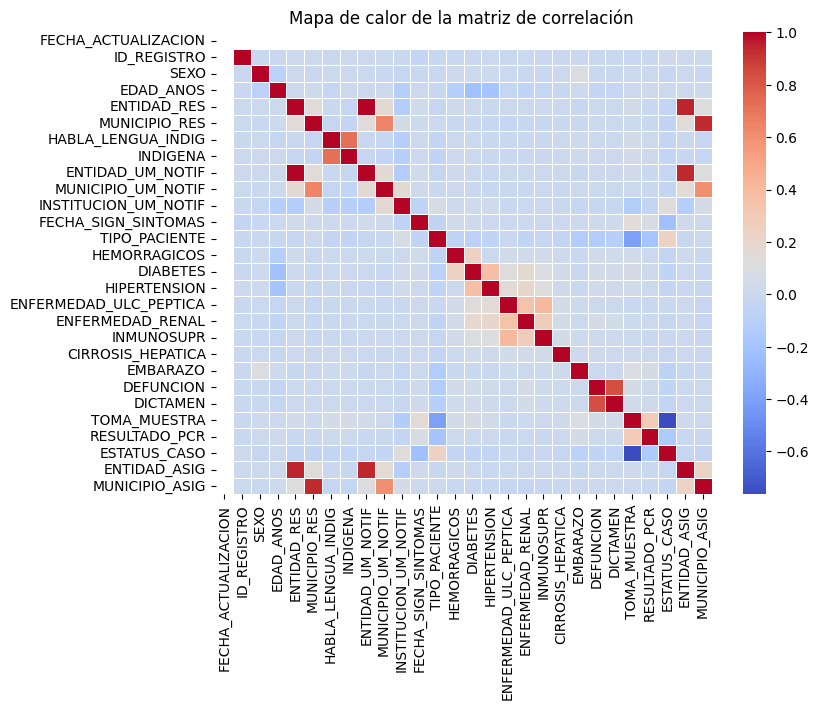

In [62]:
# Calculamos matriz de correlación
matriz_corelacion = df.corr()

# Graficamos la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corelacion, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de calor de la matriz de correlación ')
plt.show()

### Creación de vistas y funciones para la base de datos

In [44]:
# Cerrar la conexión
conn.close()

### Conclusión